# Be able to put in posteriors from cue, get out some measure of the difference between the observed flux and what's predicted from the emulator for a set of emission lines

In [ ]:
import numpy as np
import dill as pickle
import matplotlib
import corner
from matplotlib import pyplot as plt
from pkg_resources import resource_filename
from scipy.stats import gaussian_kde
from scipy import optimize
import cue
from cue.line import predict
from cue.utils import (c, cont_lam, new_sorted_line_name, 
                       logQ, Qtotal,
                       get_loglinear_spectra, ionparam2norm, calcQ) # this includes some constants and functions for the fits and output plots

"Necessary functions to use later"
# goodness of fit function for emission lines. 
# The noise here is only the observational noise, different than the one in likelihood function, where we also account for the emulator noise.
def compare_pred_and_obs(fit, galaxy_data):
    "fit: predicted lines from the cloudy emulator"
    "observed_galaxy: observed fluxes, same as input to cue"
    "wav_ind_obs: indices in the line list of the observed lines in the galaxy"
    "wav_ind_up: indices in the line list of the lines we can use as limits in the galaxy"

    wav_ind, = np.where((galaxy_data['line_lum']!=0) | (galaxy_data['line_lum_up']!=0))
    wav_ind_obs, = np.where(galaxy_data['line_lum']!=0)  # indices where line is observed
    wav_ind_up, = np.where(galaxy_data['line_lum_up']!=0)


    chi = np.zeros_like(galaxy_data["line_lum"])
    chi[wav_ind_obs] = (fit[wav_ind_obs]-galaxy_data["line_lum"][wav_ind_obs]) / galaxy_data["line_lum_unc"][wav_ind_obs]
    chi[wav_ind_up] = (fit[wav_ind_up]-0) / galaxy_data["line_lum_unc"][wav_ind_up]
    
    chisq = np.sum(chi**2)
    ndof = len(chi[wav_ind])
    reduced_chisq = chisq/(ndof)

    percent_diff = np.zeros_like(galaxy_data["line_lum"])
    percent_diff[wav_ind_obs] = (fit[wav_ind_obs]-galaxy_data["line_lum"][wav_ind_obs]) / galaxy_data["line_lum"][wav_ind_obs]
    
    percent_outside = np.zeros_like(galaxy_data['line_lum'])
    percent_outside[wav_ind_obs]  = 100 * (galaxy_data['line_lum'][wav_ind_obs] - fit[wav_ind_obs]) / galaxy_data['line_lum'][wav_ind_obs]

    return reduced_chisq, chi, percent_diff, percent_outside

# define line labels of the emission lines for the plots
def formatNumber(num):
    if num % 1 == 0:
        return str(int(num))
    else:
        return str(num)
    
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value

def set_axis_style(ax, labels):
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    #ax.set_xlabel('Sample name')

round_to_n = lambda x, n: x if x == 0 else round(x, -int(np.floor(np.log10(abs(x)))) + (n - 1))
# just formatting the x labels
shortened_sorted_line_name = list()
for i in range(len(new_sorted_line_name)):
    new_name = new_sorted_line_name[i][:5] + \
    formatNumber(round_to_n(float(new_sorted_line_name[i][5:12]), 4)) + \
    new_sorted_line_name[i][12]
    if new_name[-1] == 'A':
        new_name = new_name[:-1] + r'$\mathrm{\AA}$'
    if new_name[-1] == 'm':
        new_name = new_name[:-1] + r'$\mathrm{\mu}$m'
    shortened_sorted_line_name.append(new_name)
shortened_sorted_line_name = np.array(shortened_sorted_line_name)

cue_line_list = np.array(['H  1 923.150A', 'H  1 926.226A', 'H  1 930.748A', 'H  1 937.804A', 'H  1 949.743A', 'H  1 972.537A', 'H  1 1025.72A', 'H  1 1215.67A', 
                          'S  4 1406.02A', 'C  4 1548.19A', 'C  4 1550.77A', 'He 2 1640.41A', 'O  3 1660.81A', 'O  3 1666.15A', 'N  3 1750.00A', 'Ne 3 1814.56A',
                          'Al 3 1854.72A', 'Al 3 1862.79A', 'Si 3 1882.71A', 'Si 3 1892.03A','C  3 1906.68A', 'C  3 1908.73A', 'N  2 2142.77A', 'O  3 2320.95A', 
                          'C  2 2323.50A', 'C  2 2324.69A', 'C  2 2325.40A', 'C  2 2326.93A','C  2 2328.12A', 'Ne 4 2424.28A', 'O  2 2471.00A', 'Al 2 2660.35A',
                          'Al 2 2669.15A', 'Mg 2 2795.53A', 'Mg 2 2802.71A', 'Ar 3 3109.18A', 'Ne 3 3342.18A', 'S  3 3721.63A', 'O  2 3726.03A', 'O  2 3728.81A',
                          'H  1 3797.90A', 'H  1 3835.38A', 'Ne 3 3868.76A', 'He 1 3888.64A','H  1 3889.05A', 'Ne 3 3967.47A', 'H  1 3970.07A', 'S  2 4068.60A',
                          'S  2 4076.35A', 'H  1 4101.73A', 'H  1 4340.46A', 'O  3 4363.21A', 'He 1 4471.50A', 'C  1 4621.57A', 'He 2 4685.68A', 'Ar 4 4711.26A',
                          'Ne 4 4720.00A', 'Ar 4 4740.12A', 'H  1 4861.32A', 'O  3 4958.91A','O  3 5006.84A', 'Ar 3 5191.82A', 'N  1 5200.26A', 'Cl 3 5517.71A',
                          'Cl 3 5537.87A', 'O  1 5577.34A', 'N  2 5754.61A', 'He 1 5875.66A','O  1 6300.30A', 'S  3 6312.06A', 'O  1 6363.78A', 'N  2 6548.05A',
                          'H  1 6562.80A', 'N  2 6583.45A', 'He 1 6678.15A', 'S  2 6716.44A','S  2 6730.82A', 'He 1 7065.25A', 'Ar 3 7135.79A', 'O  2 7323.00A',
                          'O  2 7332.00A', 'Ar 4 7332.15A', 'Ar 3 7751.11A', 'Cl 2 8578.70A','C  1 8727.13A', 'H  1 9014.91A', 'S  3 9068.62A', 'Cl 2 9123.60A',
                          'H  1 9229.02A', 'S  3 9530.62A', 'H  1 9545.97A', 'C  1 9850.00A','H  1 1.00494m', 'S  2 1.03364m', 'He 1 1.08291m', 'He 1 1.08303m',
                          'H  1 1.09381m', 'Fe 2 1.25668m', 'H  1 1.28181m', 'H  1 1.73621m','H  1 1.81741m', 'H  1 1.87510m', 'H  1 1.94456m', 'H  1 2.16553m',
                          'H  1 2.62515m', 'H  1 3.03837m', 'H  1 3.29609m', 'H  1 3.73954m','H  1 4.05113m', 'H  1 4.65251m', 'H  1 5.12726m', 'H  1 5.90660m',
                          'Ar 2 6.98337m', 'H  1 7.45782m', 'H  1 7.50045m', 'Ar 3 8.98898m','S  4 10.5076m', 'H  1 12.3685m', 'Ne 2 12.8101m', 'Cl 2 14.3639m',
                          'Ne 3 15.5509m', 'S  3 18.7078m', 'Ar 3 21.8253m', 'P  2 32.8629m','S  3 33.4704m', 'Si 2 34.8046m', 'Ne 3 36.0036m', 'O  3 51.8004m',
                          'N  3 57.3238m', 'P  2 60.6263m', 'O  1 63.1679m', 'O  3 88.3323m','N  2 121.769m', 'O  1 145.495m', 'C  2 157.636m', 'N  2 205.283m',
                          'C  1 370.269m', 'C  1 609.590m'])

galaxy_names = ["BX216", "BX274", "BX336", "BX341", "BX348", "BX350", "BX390", "BX418", "BX429", "BX461", "BX474", "BX523", "BX587", "BX628", "D40", "fBM40", "fBM47", "fC23", "MD41"]

In [ ]:
def get_kde_and_max(distribution, n_samples, initial_guess):
    kernel = gaussian_kde(distribution, bw_method="scott")  # default bandwidth is scott
    x_range = np.linspace(min(distribution),max(distribution), n_samples)
    kde = kernel.evaluate(x_range)

    # find maximum of kde
    opt = optimize.minimize(lambda x: -kernel(x), initial_guess)
    opt_value = opt.x

    return x_range, kde, opt_value

In [99]:
def get_linepredictions_forarun(galaxy, endtag):
    "Given a galaxy's results from cue, compute line predictions and deviations from observations for the galaxy"
    with open("cue-results/"+galaxy+"_results_"+endtag+"_stellar.pkl", 'rb') as f:
        cue_results = pickle.load(f)
    cue_results.keys()

    with open("line_luminosities/"+galaxy+"_fluxSN.pkl", 'rb') as f:
        obs_gal = pickle.load(f)
    obs_gal.keys()

    # median and 1-sigma range of the emission line and nebular continuum
    from dynesty.utils import resample_equal
    theta_arr = resample_equal(cue_results.samples, np.exp(cue_results.logwt-cue_results.logz[-1]), rstate=None) 
                                 # resamples a set of points from the weighted set of inputs such that they all have equal weight
    line_preds = list()
    cont_pred = list()
    u_preds = list()
    oh_preds = list()
    for ind in range(len(theta_arr)):
        # for literally every chain, 
        par = theta_arr[ind].copy()
        u_preds.append(par[7]) # just to save the ionization parameters
        oh_preds.append(par[9])
        par[7] = logQ(par[7], lognH=par[8])  # convert U into the dimensional ionization parameter
        par[8] = 10**par[8]
        "predict the lines for every single point in the cue posteriors"
        line_preds.append(predict(theta=np.array(par[:12]).reshape(1, 12), 
                                line_ind=np.arange(138)).nn_predict()[1]/10**par[7]*10**par[12])     # based on the parameters in the theta array, predict lines
        cont_pred.append(cue.continuum.predict(theta=np.array(par[:12]).reshape(1, 12)).nn_predict()[1]/\
        10**par[7]*10**par[12])

    "get median and 16th and 84th percentile of the line predictions"
    low_line, med_line, up_line = np.quantile(np.array(line_preds), [0.16, 0.5, 0.84], axis=0)  # gets the 16% probability, median, and 84% probability
    #low_cont, med_cont, up_cont = np.quantile(np.array(cont_pred), [0.16, 0.5, 0.84], axis=0)

    "calculate chi of entire distribution, and then the chi for the median, low, and up line predictions"
    chi_preds = [compare_pred_and_obs(i, obs_gal)[1] for i in line_preds]
    linechi_low = compare_pred_and_obs(low_line, obs_gal)[1]
    linechi_up = compare_pred_and_obs(up_line, obs_gal)[1]
    linechi_med = compare_pred_and_obs(med_line, obs_gal)[1]      # gets the chi of the median predicted value of all the lines, basically 
    """IS THE CHI OF THE MEDIAN THE SAME AS THE MEDIAN OF THE CHI DISTRIBUTION???"""

    percentdiffs = [compare_pred_and_obs(i, obs_gal)[2] for i in line_preds]
    percentdiff_low = compare_pred_and_obs(low_line, obs_gal)[2]
    percentdiff_up = compare_pred_and_obs(up_line, obs_gal)[2]
    percentdiff_med = compare_pred_and_obs(med_line, obs_gal)[2]

    percent_outside = [compare_pred_and_obs(i, obs_gal)[3] for i in line_preds]

    "just saving the distributions right now"
    return line_preds, chi_preds, percentdiffs, percent_outside, u_preds, oh_preds #med_line, low_line, up_line, \
            # linechi_med, linechi_low, linechi_up,  \
             #percentdiff_med, percentdiff_low, percentdiff_up

In [ ]:
def get_distribution_anyline(distribution, linename, galaxy):
    "get the median value (and 1st and 3rd quartile) of your chosen distribution (raw line prediction, chi, percent diffs) for a certain line"
    "todo: also get the max density point of the distribution"
    distribution = np.array(distribution)

    line_ind, = np.where(cue_line_list == linename)[0]

    line_distribution = distribution[:,line_ind]  # get all predictions (based on all posterior points) for a certain line
    quartile1, median, quartile3 = np.percentile(line_distribution, [25, 50, 75], axis=0)
    #plt.hist(line_distribution, density=True)

    #kernel = gaussian_kde(line_distribution, bw_method="scott")  # default bandwidth is scott

    # n_samples = len(line_distribution)
    # x_range = np.linspace(min(line_distribution),max(line_distribution), n_samples)
    # kde = kernel.evaluate(x_range)
    # plt.plot(x_range, kde)
    # plt.show()
    #opt = optimize.minimize_scalar(lambda x: -kernel(x))

    return line_distribution, np.float64(median), np.float64(quartile1), np.float64(quartile3), galaxy #, *opt.x

In [ ]:
name_inds = np.arange(1,len(galaxy_names)+1)
import matplotlib.patches as mpatches

def plot_all_violins(list_for_some_line, line_name, main_ax, hist_ax, color):
    
    line_pred = [i[0] for i in list_for_some_line]
    meds = [i[1] for i in list_for_some_line]
    q1 = [i[2] for i in list_for_some_line]
    q3 = [i[3] for i in list_for_some_line]

    # make histogram
    for i in range(len(galaxy_names)):
        if (meds[i] != 0) & (meds[i] != -0.999999999999999):  # if the line is observed, so if the median isn't exactly zero
            hist_ax.hist(line_pred[i], bins="auto", histtype="step", stacked=True, color = color)
        else:
            continue

    # plot violin plot
    viplot = main_ax.violinplot(line_pred, showmeans=False, showmedians=False, showextrema=False, orientation="horizontal")
    viplot['bodies'][-1].set_label(line_name)
    
    for piece in viplot["bodies"]:
        piece.set_facecolor(color)
        piece.set_edgecolor("black")
        piece.set_alpha(0.25)

    for i in range(len(list_for_some_line)):
        if (meds[i] != 0) & (meds[i] != -0.999999999999999):
            x_kde, kde, kde_max = get_kde_and_max(list_for_some_line[i][0], 2000, list_for_some_line[i][1]) 
            main_ax.scatter(kde_max, name_inds[i],marker = "s", zorder=5, color=color)
    
    main_ax.hlines(name_inds, q1, q3, color='black', linestyle='-', lw=2)

## get percent differences from all galaxies

In [ ]:
linepreds_allgalaxies, chipreds_allgalaxies, percentdiffs_allgalaxies, percent_outside = [],[],[], []
for galaxyname in galaxy_names:
    endtag = "nolowion_noarsulf"
    if galaxyname == "BX390":
        endtag+="_fluxSN"
    line_preds, chi_preds, percentdiffs, percentoutside, u_preds, oh_preds = get_linepredictions_forarun(galaxyname, endtag)
    linepreds_allgalaxies.append(line_preds)
    chipreds_allgalaxies.append(chi_preds)
    percentdiffs_allgalaxies.append(percentdiffs)
    percent_outside.append(percentoutside)

# [O I] and [O II]

In [ ]:
o1_deltas_all_galaxies = [get_distribution_anyline(percentdiffs_allgalaxies[i], "O  1 6300.30A", galaxy_names[i]) for i in range(len(galaxy_names))]
o2_3726_deltas_all_galaxies = [get_distribution_anyline(percentdiffs_allgalaxies[i], 'O  2 3726.03A', galaxy_names[i]) for i in range(len(galaxy_names))]
o2_3729_deltas_all_galaxies = [get_distribution_anyline(percentdiffs_allgalaxies[i], 'O  2 3728.81A', galaxy_names[i]) for i in range(len(galaxy_names))]
o3_4959_deltas_all_galaxies = [get_distribution_anyline(percentdiffs_allgalaxies[i], "O  3 4958.91A", galaxy_names[i]) for i in range(len(galaxy_names))]
o3_5007_deltas_all_galaxies = [get_distribution_anyline(percentdiffs_allgalaxies[i], "O  3 5006.84A", galaxy_names[i]) for i in range(len(galaxy_names))]

In [ ]:
o1_outside_all_galaxies = [get_distribution_anyline(percent_outside[i], "O  1 6300.30A", galaxy_names[i]) for i in range(len(galaxy_names))]
o2_3726_outside_all_galaxies = [get_distribution_anyline(percent_outside[i], 'O  2 3726.03A', galaxy_names[i]) for i in range(len(galaxy_names))]
o2_3729_outside_all_galaxies = [get_distribution_anyline(percent_outside[i], 'O  2 3728.81A', galaxy_names[i]) for i in range(len(galaxy_names))]
o3_4959_outside_all_galaxies = [get_distribution_anyline(percent_outside[i], "O  3 4958.91A", galaxy_names[i]) for i in range(len(galaxy_names))]
o3_5007_outside_all_galaxies = [get_distribution_anyline(percent_outside[i], "O  3 5006.84A", galaxy_names[i]) for i in range(len(galaxy_names))]

In [ ]:
fig, (histax, mainax) = plt.subplots(nrows=2, ncols=1, figsize=(10,15), height_ratios=[1,6], sharex=True, gridspec_kw={'hspace': 0})
plot_all_violins(o1_outside_all_galaxies,"[O I] 6300",mainax,histax,"red")
plot_all_violins(o3_5007_outside_all_galaxies,"[O III] 5007",mainax,histax,"green")
mainax.set_xlim(-100,100)
mainax.set_yticks(name_inds, labels=galaxy_names)
mainax.set_xlabel(r"$\%$ flux coming from outside of HII region", fontsize=14)
mainax.set_ylabel("galaxy", fontsize=14)
plt.show()

need to fix the like, interquartile range here

## quantify with max of kde of the overall distributions

In [ ]:
# make big o1 distribution from all the individual galaxies

# maybe some kind of pandas dataframeso we can use scipy?
from scipy import stats
def flatten_comprehension(matrix):
     return [item for row in matrix for item in row]

print("num obs, minmax, mean, variance, skewness, kurtosis \n")

o1_line_diffs = flatten_comprehension(([i[0] for i in o1_outside_all_galaxies if i[1] !=0]))
print(*stats.describe(o1_line_diffs))
print("standard error of the mean of o1 distribution", stats.sem(o1_line_diffs), "\n")
print("iqr")

o3_line_diffs = flatten_comprehension(([i[0] for i in o3_5007_outside_all_galaxies if i[1] !=0]))
print(*stats.describe(o3_line_diffs))
print("standard error of the mean o1 distribution", stats.sem(o3_line_diffs))


### kde of big histograms

In [ ]:
x_kde_o3, kde_o3, o3_max = get_kde_and_max(o3_line_diffs, 2000, 0)
x_kde_o1, kde_o1, o1_max = get_kde_and_max(o1_line_diffs, 2000, 50)

In [ ]:
plt.figure(figsize=(10,7))
#plt.hist(o1_line_diffs, bins="auto",  histtype="step", stacked=True, color = "red")
#plt.hist(o3_line_diffs, bins="auto",  histtype="step", stacked=True, color = "green")
plt.plot(x_kde_o3, kde_o3, color="green", label="o3")
plt.plot(x_kde_o1, kde_o1, color="red", label="o1")
plt.axvline(o1_max, c = "red")
plt.axvline(o3_max, c = "green")
plt.xlabel(r"$\%$ flux coming from outside of HII region", fontsize=14)
plt.xlim(-100,100)
plt.legend()
plt.show()

print("o3 max at", o3_max, "o1 max at", o1_max)
#print("diff", o3_max-o1_max)


## violin plot with big distributions

In [ ]:
fig, (histax, mainax) = plt.subplots(nrows=2, ncols=1, figsize=(10,15), height_ratios=[1,6], sharex=True, gridspec_kw={'hspace': 0})
o1_line_pred = [i[0] for i in o1_outside_all_galaxies]
o1_meds = [i[1] for i in o1_outside_all_galaxies]
o1_q1 = [i[2] for i in o1_outside_all_galaxies]
o1_q3 = [i[3] for i in o1_outside_all_galaxies]

# make histogram
histax.plot(x_kde_o1, kde_o1, color="red", label="o1")
histax.axvline(o1_max, c = "red")

# plot violin plot
viplot = mainax.violinplot(o1_line_pred, showmeans=False, showmedians=False, showextrema=False, orientation="horizontal")
viplot['bodies'][-1].set_label("[O I]6300")

for piece in viplot["bodies"]:
    piece.set_facecolor("red")
    piece.set_edgecolor("black")
    piece.set_alpha(0.25)
mainax.scatter(o1_meds, name_inds,marker = "s", zorder=5, color="red")
mainax.hlines(name_inds, o1_q1, o1_q3, color='black', linestyle='-', lw=2)


o3_line_pred = [i[0] for i in o3_5007_outside_all_galaxies]
o3_meds = [i[1] for i in o3_5007_outside_all_galaxies]
o3_q1 = [i[2] for i in o3_5007_outside_all_galaxies]
o3_q3 = [i[3] for i in o3_5007_outside_all_galaxies]

# make histogram
histax.plot(x_kde_o3, kde_o3, color="green", label="o3")
histax.axvline(o3_max, c = "green")

# plot violin plot
viplot = mainax.violinplot(o3_line_pred, showmeans=False, showmedians=False, showextrema=False, orientation="horizontal")
viplot['bodies'][-1].set_label("[O III]5007")

for piece in viplot["bodies"]:
    piece.set_facecolor("green")
    piece.set_edgecolor("black")
    piece.set_alpha(0.25)
mainax.scatter(o3_meds, name_inds,marker = "s", zorder=5, color="green")
mainax.hlines(name_inds, o3_q1, o3_q3, color='black', linestyle='-', lw=2)


mainax.set_xlim(-100,100)
mainax.set_yticks(name_inds, labels=galaxy_names)
mainax.set_xlabel(r"$\%$ flux coming from outside of HII region", fontsize=14)
plt.show()

## KDEs for individual galaxies

In [ ]:
percent_outside_o1_each_galaxy_from_kde = []
for i in range(len(galaxy_names)):
    # print(galaxy_names[i])
    # print("median", o1_outside_all_galaxies[i][1])
    if o1_outside_all_galaxies[i][1] != 0:
        x_kde_o1, kde_o1, o1_max = get_kde_and_max(o1_outside_all_galaxies[i][0], 2000, o1_outside_all_galaxies[i][1])  # uses median as initial guess
        #print("percent outside", o1_max, "\n")
        plt.plot(x_kde_o1, kde_o1)
        #plt.axvline(o1_max)
        #plt.axvline(o1_outside_all_galaxies[i][1], c="black")
        plt.xlim(0,100)
        percent_outside_o1_each_galaxy_from_kde.append(*o1_max)
    else:
        percent_outside_o1_each_galaxy_from_kde.append(0)
plt.show()
    

In [ ]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.scatter(name_inds, percent_outside_o1_each_galaxy_from_kde, marker = "s", color = "red")
plt.xticks(name_inds, labels=galaxy_names, rotation=90)
plt.ylabel("percent of flux from outside the HII region from kde")
plt.subplot(1,2,2)
plt.scatter(name_inds, percent_outside_o1_each_galaxy_from_kde, marker="s", color="red")
plt.xticks(name_inds, labels=galaxy_names, rotation=90)
plt.ylim(70,100)
plt.show()


# S2 and S3

## violin plot

In [ ]:
# s2_6717_outside_all_galaxies = [get_distribution_anyline(percent_outside[i], 'S  2 6716.44A', galaxy_names[i]) for i in range(len(galaxy_names))]
# s2_6731_outside_all_galaxies = [get_distribution_anyline(percent_outside[i], 'S  2 6730.82A', galaxy_names[i]) for i in range(len(galaxy_names))]
# s3_9069_outside_all_galaxies = [get_distribution_anyline(percent_outside[i], 'S  3 9068.62A', galaxy_names[i]) for i in range(len(galaxy_names))]
# s3_9531_outside_all_galaxies = [get_distribution_anyline(percent_outside[i], 'S  3 9530.62A', galaxy_names[i]) for i in range(len(galaxy_names))]

In [97]:
s2_6717_preds_all_galaxies = [get_distribution_anyline(linepreds_allgalaxies[i], 'S  2 6716.44A', galaxy_names[i]) for i in range(len(galaxy_names))]
s2_6731_preds_all_galaxies = [get_distribution_anyline(linepreds_allgalaxies[i], 'S  2 6730.82A', galaxy_names[i]) for i in range(len(galaxy_names))]
s3_9069_preds_all_galaxies = [get_distribution_anyline(linepreds_allgalaxies[i], 'S  3 9068.62A', galaxy_names[i]) for i in range(len(galaxy_names))]
s3_9531_preds_all_galaxies = [get_distribution_anyline(linepreds_allgalaxies[i], 'S  3 9530.62A', galaxy_names[i]) for i in range(len(galaxy_names))]

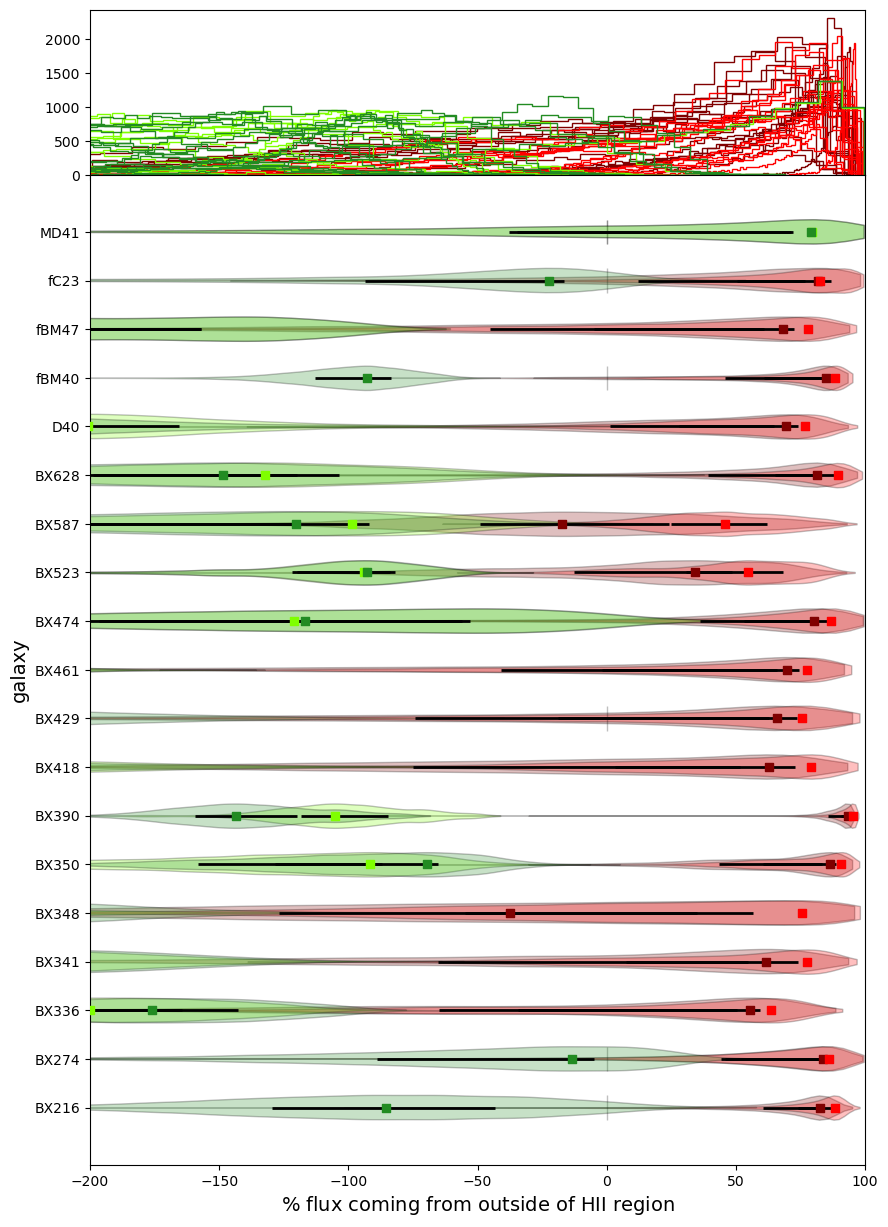

In [98]:
fig, (histax, mainax) = plt.subplots(nrows=2, ncols=1, figsize=(10,15), height_ratios=[1,6], sharex=True, gridspec_kw={'hspace': 0})
plot_all_violins(s2_6731_outside_all_galaxies, "[S II] 6731",mainax,histax,"maroon")
plot_all_violins(s2_6717_outside_all_galaxies, "[S II] 6717",mainax,histax,"red")
plot_all_violins(s3_9069_outside_all_galaxies, "[S III] 9069",mainax,histax,"chartreuse")
plot_all_violins(s3_9531_outside_all_galaxies, "[S III] 9531",mainax,histax,"forestgreen")
mainax.set_xlim(-200,100)
mainax.set_yticks(name_inds, labels=galaxy_names)
mainax.set_xlabel(r"$\%$ flux coming from outside of HII region", fontsize=14)
mainax.set_ylabel("galaxy", fontsize=14)
plt.show()

## scale s3 and s2 by s/o

In [ ]:
# get galaxy S/O just from a text file
import pandas as pd
abunds = pd.read_csv('/home/carolinevr/CECILIA-MOS/cecilia-abunds.txt', sep=',', header=None, names = ["galaxy", "12+log(o/h)", "log(n/o)", "log(s/o)", "log(ar/o)"])

def get_so_for_galaxy(galaxy):
    galaxyind = (abunds['galaxy']==galaxy)
    return np.float64(abunds['log(s/o)'][galaxyind])

print(get_so_for_galaxy(galaxy_names[0]))

# scale line predictions... and then get the percent difference? because I can just readin the observed values and get the percent from outside the hii region then

# random test plots

In [101]:
s3_9531_outside_all_galaxies = []
for i in range(len(galaxy_names)):
    # get the line prediction for s3 9531 from the emulator 
    s3_linepred = get_distribution_anyline(linepreds_allgalaxies[i], 'S  3 9530.62A', galaxy_names[i])
    # get the s/o for the specific galaxy
    logso = get_so_for_galaxy(galaxy_names[i])
    # now scale the line prediction by the multiplicative factor, because cloudy outputs are not in log
    so_scaling = 10**(logso+1.57)

    s3_linepred = [m*so_scaling for m in s3_linepred]
    
    with open("line_luminosities/"+galaxy_names[i]+"_fluxSN.pkl", 'rb') as f:
        obs_gal = pickle.load(f)
    obs_gal.keys()

    s3_ind = (obs_gal['line_name'] == 'S  3 9530.62A')
    s3_lineobs = obs_gal['line_lum'][s3_ind]

    percent_outside_distribution = []

    for j in s3_linepred:
        percent_outside  = 100 * (s3_lineobs - j) / s3_lineobs
        percent_outside_distribution.append(percent_outside)

    s3_9531_outside_all_galaxies.append(percent_outside_distribution)



/tmp/ipykernel_408324/2533662545.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return np.float64(abunds['log(s/o)'][galaxyind])


TypeError: can't multiply sequence by non-int of type 'numpy.float64'

## plotting deltas against 1:1 line

## random plots

In [ ]:
# plt.figure(figsize=(10,3))
# plt.subplot(1,2,1)
# plt.title("s2 comp")
# for i in range(len(galaxy_names)):
#     plt.scatter(s2_6717_deltas_all_galaxies[i][1], s2_6731_deltas_all_galaxies[i][1], label = galaxy_names[i])
# plt.grid()
# plt.plot(np.arange(-1.0,0.4,0.1), np.arange(-1.0,0.4,0.1), ls = "--")
# plt.xlabel("(fit-obs)/obs, 6717", fontsize=16)
# plt.ylabel("(fit - obs)/obs, 6731", fontsize=14)
# #plt.legend()
# plt.subplot(1,2,2)
# plt.title("s3 comp")
# for i in range(len(galaxy_names)):
#     plt.scatter(s3_9069_deltas_all_galaxies[i][1], s3_9531_deltas_all_galaxies[i][1], label = galaxy_names[i])

# plt.plot(np.arange(-1.0,4,0.1), np.arange(-1.0,4,0.1), ls = "--")
# plt.grid()
# #plt.legend()
# plt.xlabel("(fit-obs)/obs, 9069", fontsize=14)
# plt.ylabel("(fit - obs)/obs, 9531", fontsize=14)
# plt.show()


# plt.figure(figsize=(8,3))
# plt.title("comparison of difference in both sulfur lines for both ions")
# for i in range(len(galaxy_names)):
#     plt.scatter(s3_9069_deltas_all_galaxies[i][1]+s3_9531_deltas_all_galaxies[i][1], s2_6717_deltas_all_galaxies[i][1]+s2_6731_deltas_all_galaxies[i][1],label = galaxy_names[i])
# plt.grid()
# plt.plot(np.arange(-2,7,1), np.arange(-2,7,1), ls= "--")
# plt.ylabel(r"$\Delta$s2, total", fontsize=16)
# plt.xlabel(r"$\Delta$s3, total", fontsize=16)
# plt.show()

still how to understand the degeneracy with U? if we expect all the sulfur flux is from the hii region, the deviation from the 1:1 line would depend on what state the sulfur is in, thus the ionization parameter. 

## plotting predictions against 1:1 line

In [ ]:
s2_6717_preds_all_galaxies = [get_distribution_anyline(linepreds, 'S  2 6716.44A') for linepreds in linepreds_allgalaxies]
s2_6731_preds_all_galaxies = [get_distribution_anyline(linepreds, 'S  2 6730.82A') for linepreds in linepreds_allgalaxies]
s3_9069_preds_all_galaxies = [get_distribution_anyline(linepreds, 'S  3 9068.62A') for linepreds in linepreds_allgalaxies]
s3_9531_preds_all_galaxies = [get_distribution_anyline(linepreds, 'S  3 9530.62A') for linepreds in linepreds_allgalaxies]


plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.title("s2 comp")
for i in range(len(galaxy_names)):
    plt.scatter(s2_6717_preds_all_galaxies[i][1], s2_6731_preds_all_galaxies[i][1], label = galaxy_names[i])
plt.grid()
plt.plot(np.arange(-1.0,0.4,0.1), np.arange(-1.0,0.4,0.1), ls = "--")
plt.xlabel("pred 6717", fontsize=16)
plt.ylabel("pred 6731", fontsize=14)
#plt.legend()
plt.subplot(1,2,2)
plt.title("s3 comp")
for i in range(len(galaxy_names)):
    plt.scatter(s3_9069_preds_all_galaxies[i][1], s3_9531_preds_all_galaxies[i][1], label = galaxy_names[i])

plt.plot(np.arange(-1.0,4,0.1), np.arange(-1.0,4,0.1), ls = "--")
plt.grid()
#plt.legend()
plt.xlabel("pred 9069", fontsize=14)
plt.ylabel("pred 9531", fontsize=14)
plt.show()


# plt.figure(figsize=(10,6))
# plt.title("comparison of difference in both sulfur lines for both ions")
# for i in range(len(galaxy_names)):
#     plt.scatter(s3_9069_preds_all_galaxies[i][1]+s3_9531_preds_all_galaxies[i][1], s2_6717_preds_all_galaxies[i][1]+s2_6731_preds_all_galaxies[i][1],label = galaxy_names[i])
# plt.grid()
# plt.ylabel(r"pred s2, total", fontsize=16)
# plt.xlabel(r"pred s3, total", fontsize=16)
# plt.show()

median U is not necessarily U used for median line prediction. what does it all mean. looking at the actual distribution should mitigate this, though. because it's clearly sampling -3.0 to -1.0 ish. so, for all U it is sampling, s2 is still under-fit. It actually doesn't matter what U is... or does it? need to think on this more. 

In [ ]:
line_preds, chi_preds, percentdiffs, u_preds, oh_preds = get_linepredictions_forarun("D40", "nolowion_noarsulf")

s3_diffs= (np.array(get_distribution_anyline(percentdiffs, 'S  3 9068.62A')[0])+np.array(get_distribution_anyline(percentdiffs, 'S  3 9530.62A')[0])) 
s2_diffs = (np.array(get_distribution_anyline(percentdiffs, 'S  2 6716.44A')[0])+np.array(get_distribution_anyline(percentdiffs, 'S  2 6730.82A')[0]))


plt.scatter(s3_diffs, s2_diffs, c=u_preds, alpha = 0.5)
plt.colorbar()
plt.ylabel(r"$\Delta$S2", fontsize=16)
plt.xlabel(r"$\Delta$S3", fontsize=16)
plt.plot(np.arange(-2,7,1), np.arange(-2,7,1), ls= "--")
plt.show()

## Plot delta s2 and delta s3 as a function of galaxy S/O

In [ ]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
for i in range(len(galaxy_names)):
    if get_so_for_galaxy(galaxy_names[i]) != 0:
        plt.scatter(get_so_for_galaxy(galaxy_names[i]), s2_6717_deltas_all_galaxies[i][1]+s2_6731_deltas_all_galaxies[i][1],label = galaxy_names[i], marker="s", edgecolors="black")
plt.ylim(-2,7)
plt.ylabel(r"$\Delta$S2", fontsize=16)
plt.xlabel("log(S/O)", fontsize=16)
plt.axvline(-1.57, color="red", ls="--")
plt.subplot(1,2,2)
for i in range(len(galaxy_names)):
    if get_so_for_galaxy(galaxy_names[i]) != 0:
        plt.scatter(get_so_for_galaxy(galaxy_names[i]), s3_9069_deltas_all_galaxies[i][1]+s3_9531_deltas_all_galaxies[i][1],label = galaxy_names[i], marker="s", edgecolors="black")
plt.ylim(-2,7)
plt.ylabel(r"$\Delta$S3", fontsize=16)
plt.xlabel("log(S/O)", fontsize=16)
plt.axvline(-1.57, color="red", ls="--")
plt.show()
plt.figure(figsize=(8,5))
for i in range(len(galaxy_names)):
    if get_so_for_galaxy(galaxy_names[i]) != 0:
        plt.scatter(get_so_for_galaxy(galaxy_names[i]), (s3_9069_deltas_all_galaxies[i][1]+s3_9531_deltas_all_galaxies[i][1])-(s2_6717_deltas_all_galaxies[i][1]+s2_6731_deltas_all_galaxies[i][1]),label = galaxy_names[i], marker="s", edgecolors="black")
plt.ylim(0,10)
plt.ylabel(r"$\Delta$S3-$\Delta$S2", fontsize=16)
plt.xlabel("log(S/O)", fontsize=16)
plt.axvline(-1.57, color="red", ls="--")
plt.show()

even when S/O is solar, s3 is over-predicted and s2 is under-predicted. 

hmmmmm!!!!!!! maybe there's a baseline amount that s3 is over-predicted relative to s2. 

no because what does this even mean honestly. 

In [ ]:
import os
from astropy.io import fits
path = os.path.join('/home/carolinevr/ABUND_20250918_v2', "cecilia_2593_22.abund.fits")
# Open fits file
hdu = fits.open(path)

g235m = hdu[1].data 
print(g235m)
mos = hdu[7].data 
print(mos)